In [1]:
import os
import sys

# Move the working directory and change directory to the parent folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
os.chdir(parent_dir)


In [ ]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, TypedDict, Union

from langchain_core.messages import AnyMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.types import Command
from src.logger_initialization import initialize_logger
from typing_extensions import Annotated, Literal
import pandas as pd


In [3]:
from src.agents import (
    full_information_grader_agent,
    question_rewriter_agent,
    company_metric_agent,
)
from src.parsing_utils import (
    add_credibility_web_search,
    create_retriever_in_memory,
    exa_search_results,
    retrieve_with_credibility,
)


2025-12-29 08:07:48 - parsing_utils_logger - INFO - Logger 'parsing_utils_logger' initialized with log file: logs\parsing_utils_2025-12-29.log


In [4]:
logger = initialize_logger("table_graph")

2025-12-29 08:07:49 - table_graph_logger - INFO - Logger 'table_graph_logger' initialized with log file: logs\table_graph_2025-12-29.log


In [5]:
MAX_RETRIES = 1

## Creating graph

In [6]:
class One_metricsGraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        retry_count: retry count initialized to 0
    """

    company_name: str = ""
    metrics: str = ""

    generation: str = ""
    follow_up_question: str = ""
    documents: List[str] = field(default_factory=list)
    retry_count: int = 0
    parameters: List[str] = field(default_factory=list)
    web_results: List[str] = field(default_factory=list)

In [7]:
async def retries_increment_node(
    state, config: RunnableConfig
) -> Command[Literal["question_rewriter_node", END]]:
    thread_id = config["configurable"]["thread_id"]

    retry_count = state.get("retry_count", 0)
    incremented_retry_count = retry_count + 1

    logger.info(
        f"Thread: {thread_id} - Retry count increment {incremented_retry_count}"
    )
    logger.info(f"---RETRY COUNT INCREMENT {incremented_retry_count}---")

    if incremented_retry_count >= MAX_RETRIES:
        logger.info(f"Thread: {thread_id} - Reached maximum number of retries, stop")
        return Command(
            # state update
            update={"retry_count": incremented_retry_count},
            # control flow
            goto=END,
        )
    else:
        logger.info(f"Thread: {thread_id} - Proceed to web search")
        return Command(
            # state update
            update={"retry_count": incremented_retry_count},
            # control flow
            goto="question_rewriter_node",
        )

In [8]:
async def full_answer_check_node(
    state, config: RunnableConfig
) -> Command[Literal[END, "retries_increment_node"]]:
    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Full answer check")
    company_name = state["company_name"]
    metrics = state["metrics"]
    question = f"Find {metrics} for {company_name}"
    generation = state["generation"]

    # Invoke the grading function
    input_prompt = f"User question: \n\n {question} \n\n LLM generation: {generation}"
    result = await full_information_grader_agent.run(input_prompt)
    binary_score = result.output.binary_score
    logger.info(f"Thread: {thread_id} - Full answer check result: {binary_score}")
    if binary_score:
        return Command(goto=END)

    else:
        logger.info(
            f"Thread: {thread_id} - New question: {result.output.follow_up_question}"
        )

        return Command(
            # state update
            update={"follow_up_question": result.output.follow_up_question},
            goto="retries_increment_node",
        )

In [9]:
async def generate_structured_answer_node(state, config: RunnableConfig):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Generate")
    company_name = state["company_name"]
    metrics = state["metrics"]
    question = f"Find {metrics} for {company_name}"

    documents = state["documents"]

    # RAG generation
    input_prompt = f"Question: {question} \nDocuments: {documents}"
    result = await company_metric_agent.run(input_prompt)
    generation = result.output.model_dump()
    logger.info(f"Thread: {thread_id} - Generation: {generation}")
    return {"generation": generation}

In [10]:
async def question_rewriter_node(state, config: RunnableConfig):
    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Generate")
    company_name = state["company_name"]
    metrics = state["metrics"]
    question = f"Find {metrics} for {company_name}"
    follow_up_question = state["follow_up_question"]
    documents = state["documents"]

    # RAG generation
    input_prompt = f"Question: {question} \nFollow-up question: {follow_up_question} \nDocument: {documents[:1]}"
    result = await question_rewriter_agent.run(input_prompt)
    new_question = result.output.updated_query
    logger.info(f"Thread: {thread_id} - New question: {new_question}")
    return {"question": new_question}

In [11]:
async def web_search_node(state, config: RunnableConfig):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    thread_id = config["configurable"]["thread_id"]
    logger.info(f"Thread: {thread_id} - Web search")
    company_name = state["company_name"]
    metrics = state["metrics"]
    question = f"Find {metrics} for {company_name}"
    # Web search

    web_results = await exa_search_results(question)
    logger.info(f"Thread: {thread_id} - Exa search done")
    web_results = await add_credibility_web_search(web_results, question)
    logger.info(f"Thread: {thread_id} - Credibility done")

    if web_results:
        logger.info(f"Thread: {thread_id} - Creating retriever in memory...")
        vector_store = create_retriever_in_memory(web_results)

        if vector_store is not None:
            logger.info(
                f"Thread: {thread_id} - Retrieving documents from the vectorstore..."
            )
            documents_web = retrieve_with_credibility(vector_store, question)

        else:
            documents_web = []

    else:
        documents_web = []

    return {"documents": documents_web, "web_results": web_results}

In [12]:
workflow = StateGraph(One_metricsGraphState)

# Define the nodes
workflow.add_node("web_search_node", web_search_node)  # Web search if needed

workflow.add_node(
    "generate_structured_answer_node", generate_structured_answer_node
)  # Generate response
workflow.add_node("retries_increment_node", retries_increment_node)
workflow.add_node("full_answer_check_node", full_answer_check_node)
workflow.add_node("question_rewriter_node", question_rewriter_node)


workflow.add_edge(START, "web_search_node")

workflow.add_edge("web_search_node", "generate_structured_answer_node")
workflow.add_edge("generate_structured_answer_node", "full_answer_check_node")

workflow.add_edge("question_rewriter_node", "web_search_node")

In [13]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

# Compile
one_metrics_graph = workflow.compile(checkpointer=checkpointer)

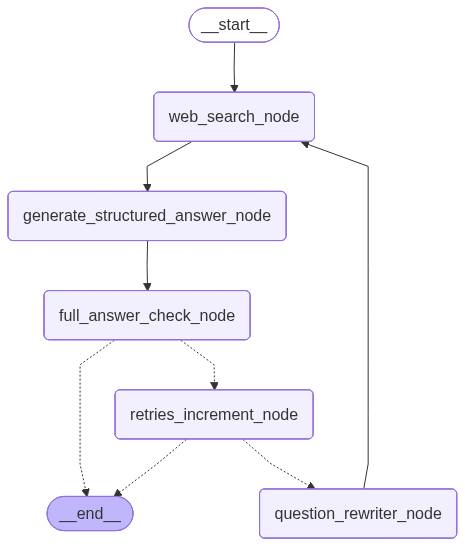

In [14]:
from IPython.display import Image, display

try:
    display(Image(one_metrics_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
thread = {"configurable": {"thread_id": "1"}, "run_name": "test_run"}

example_input = {"company_name": "euNetworks", "metrics": "ebitda"}

In [16]:
result = await one_metrics_graph.ainvoke(input=example_input, config=thread)

2025-12-29 08:07:59 - table_graph_logger - INFO - Thread: 1 - Web search
2025-12-29 08:07:59 - parsing_utils_logger - INFO - Start exa search with query: Find ebitda for euNetworks
2025-12-29 08:08:05 - parsing_utils_logger - INFO - Exa search completed with 15 results
2025-12-29 08:08:05 - parsing_utils_logger - INFO - Found 15 new documents: ['https://eunetworks.com/investor-relations/annual-reports/', 'https://www.cbinsights.com/company/eunetworks', 'https://growjo.com/company/euNetworks', 'https://tracxn.com/d/companies/eunetworks/__3JwJwA53TB5wJrVBNnZq69iz0NTy-Vo10InJord9B8E', 'https://www.telcotitans.com/infrawatch/eunetworks-lands-21bn-to-spend-on-european-data-centre-comms-play/8412.article', 'https://reports.investors.vodafone.com/view/357348140/11/', 'https://eunetworks.com/investor-relations/', 'https://eunetworks.com/services/industries/enterprise/', 'https://eunetworks.com/news/eunetworks-refinances-part-of-its-existing-debt-and-secures-additional-sustainability-linked-deb

Processing documents: 100%|██████████| 15/15 [00:00<00:00, 77195.78it/s]

2025-12-29 08:08:11 - parsing_utils_logger - INFO - Processed 15 documents
2025-12-29 08:08:11 - table_graph_logger - INFO - Thread: 1 - Exa search done
2025-12-29 08:08:11 - parsing_utils_logger - INFO - ---ADD CREDIBILITY TO DOCUMENTS---
2025-12-29 08:08:11 - parsing_utils_logger - INFO - Adding credibility to web document -- https://eunetworks.com/investor-relations/annual-reports/
2025-12-29 08:08:11 - parsing_utils_logger - INFO - Adding credibility to web document -- https://www.cbinsights.com/company/eunetworks
2025-12-29 08:08:11 - parsing_utils_logger - INFO - Adding credibility to web document -- https://growjo.com/company/euNetworks
2025-12-29 08:08:11 - parsing_utils_logger - INFO - Adding credibility to web document -- https://tracxn.com/d/companies/eunetworks/__3JwJwA53TB5wJrVBNnZq69iz0NTy-Vo10InJord9B8E
2025-12-29 08:08:11 - parsing_utils_logger - INFO - Adding credibility to web document -- https://www.telcotitans.com/infrawatch/eunetworks-lands-21bn-to-spend-on-europea

2025-12-29 08:08:13 - table_graph_logger - INFO - Thread: 1 - Credibility done
2025-12-29 08:08:13 - table_graph_logger - INFO - Thread: 1 - Creating retriever in memory...
2025-12-29 08:08:16 - parsing_utils_logger - INFO - Adding documents to the inmemory vectorstore
2025-12-29 08:08:19 - parsing_utils_logger - INFO - Documents added to the inmemory vectorstore
2025-12-29 08:08:19 - table_graph_logger - INFO - Thread: 1 - Retrieving documents from the vectorstore...
2025-12-29 08:08:20 - table_graph_logger - INFO - Thread: 1 - Generate
2025-12-29 08:08:40 - table_graph_logger - INFO - Thread: 1 - Generation: {'comment': 'Answer: euNetworks’ adjusted EBITDA was €111,900,000 for full-year 2020. According to euNetworks Benefits from Dark Fiber Trends in 2020 (https://dgtlinfra.com/eunetworks-dark-fiber-2020/), euNetworks reported “adjusted EBITDA of €111.9m” for FY2020. The company commonly reports Adjusted EBITDA, defined as Earnings Before Interest, Tax, Depreciation, Amortisation, pr

In [30]:
import asyncio
from tqdm.asyncio import tqdm


async def process_item_async(item, config):
    """Async function to process each (company, metric) pair using one_comp_metric_graph.ainvoke."""
    company, metric = item
    try:
        result_graph = await one_metrics_graph.ainvoke(
            input={"company_name": company, "metrics": metric}, config=config
        )

        return {
            "company_name": result_graph.get("company_name", company),
            "generation": result_graph.get("generation", {}),
            "metrics": result_graph.get("parameter", metric),
        }
    except Exception as e:
        logger.error(f"Error processing {company} with {metric}: {e}")
        return {
            "company_name": company,
            "generation": {"error": str(e)},
            "metrics": metric,
        }


async def process_combinations_async(combinations_list, configs):
    """Process all combinations asynchronously."""
    tasks = [
        process_item_async(item, config)
        for item, config in zip(combinations_list, configs)
    ]

    results = []
    for coro in tqdm.as_completed(tasks, desc="Processing documents"):
        result = await coro
        results.append(result)

    return results


async def process_lists(companies_list, metrics_list):
    """Main entry point that creates combinations and processes them asynchronously."""
    combinations_list = [
        (company, metric) for company in companies_list for metric in metrics_list
    ]
    configs = [
        {"configurable": {"thread_id": item[0] + item[1]}} for item in combinations_list
    ]

    processed_results = await process_combinations_async(combinations_list, configs)

    return processed_results


In [ ]:
def create_table(data):
    company_names = set()
    parameters = set()

    # Extract unique company names and parameters with exception handling
    for item in data:
        try:
            company_name = item["company_name"]
            parameter = item["metrics"]

            # Add to the sets if both company_name and parameter exist
            if company_name and parameter:
                company_names.add(company_name)
                parameters.add(parameter)
        except KeyError as e:
            # Log the error or just skip this item if there is a missing key
            logger.error(f"Skipping item due to missing key: {e}")
            continue
        except Exception as e:
            # Catch any other exceptions and skip the problematic item
            logger.error(f"Skipping item due to error: {e}")
            continue

    # Convert sets to lists
    company_names = list(company_names)
    parameters = list(parameters)

    # Initialize the DataFrame with company names as the first column
    df = pd.DataFrame(company_names, columns=["company_name"])

    # Add columns for each parameter's value and comment
    for parameter in parameters:
        df[parameter + " value"] = None
        df[parameter + " comment"] = None

    # Populate the DataFrame with values and comments
    for item in data:
        try:
            # Extract necessary information from new format
            company_name = item["company_name"]
            parameter = item["metrics"]  # Changed from "parameter" to "metrics"
            generation = item.get("generation", {})  # Get generation dict
            value = generation.get("value", None)  # Changed from retrieved_info
            comment = generation.get("comment", None)  # Changed from retrieved_info

            # Skip if any of the necessary information is missing or malformed
            if not company_name or not parameter or value is None or comment is None:
                continue  # Skip this observation

            # Update the DataFrame
            df.loc[df["company_name"] == company_name, parameter + " value"] = value
            df.loc[df["company_name"] == company_name, parameter + " comment"] = comment

        except KeyError as e:
            # Log the error or just skip this item if there is a missing key
            logger.error(f"Skipping observation due to missing key: {e}")
            continue
        except Exception as e:
            # Catch any other exceptions and skip the problematic item
            logger.error(f"Skipping observation due to error: {e}")
            continue

    return df


In [31]:
companies_list = ["euNetworks"]
metrics_list = ["EBITDA"]

# Run it
results = await process_lists(companies_list, metrics_list)


Processing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-29 08:41:46 - table_graph_logger - INFO - Thread: euNetworksEBITDA - Web search
2025-12-29 08:41:46 - parsing_utils_logger - INFO - Start exa search with query: Find EBITDA for euNetworks
2025-12-29 08:41:53 - parsing_utils_logger - INFO - Exa search completed with 15 results
2025-12-29 08:41:53 - parsing_utils_logger - INFO - Found 15 new documents: ['https://eunetworks.com/app/uploads/2024/06/ESO.04.04-Ax3-euNetworks-Holdings-LP-FS-31.12.2023-v4.pdf', 'https://eunetworks.com/app/uploads/2023/06/euNetworks-Holdings-Limited-FS-31.12.2022-vFF.pdf', 'https://www.sttinfo.fi/tiedote/64463782/eunetworks-performance-update-for-third-quarter-2017?publisherId=58763726', 'https://eunetworks.com/investor-relations/annual-reports/', 'https://www.telcotitans.com/infrawatch/eunetworks-lands-21bn-to-spend-on-european-data-centre-comms-play/8412.article', 'https://tracxn.com/d/companies/eunetworks/__3JwJwA53TB5wJrVBNnZq69iz0NTy-Vo10InJord9B8E', 'https://eunetworks.com/investor-relations/', 'h

Processing documents: 100%|██████████| 15/15 [00:00<00:00, 48284.39it/s]

2025-12-29 08:42:17 - parsing_utils_logger - INFO - Processed 15 documents
2025-12-29 08:42:17 - table_graph_logger - INFO - Thread: euNetworksEBITDA - Exa search done
2025-12-29 08:42:17 - parsing_utils_logger - INFO - ---ADD CREDIBILITY TO DOCUMENTS---
2025-12-29 08:42:17 - parsing_utils_logger - INFO - Adding credibility to web document -- https://eunetworks.com/app/uploads/2024/06/ESO.04.04-Ax3-euNetworks-Holdings-LP-FS-31.12.2023-v4.pdf
2025-12-29 08:42:17 - parsing_utils_logger - INFO - Adding credibility to web document -- https://eunetworks.com/app/uploads/2023/06/euNetworks-Holdings-Limited-FS-31.12.2022-vFF.pdf
2025-12-29 08:42:17 - parsing_utils_logger - INFO - Adding credibility to web document -- https://www.sttinfo.fi/tiedote/64463782/eunetworks-performance-update-for-third-quarter-2017?publisherId=58763726
2025-12-29 08:42:17 - parsing_utils_logger - INFO - Adding credibility to web document -- https://eunetworks.com/investor-relations/annual-reports/
2025-12-29 08:42:17

2025-12-29 08:42:20 - table_graph_logger - INFO - Thread: euNetworksEBITDA - Credibility done
2025-12-29 08:42:20 - table_graph_logger - INFO - Thread: euNetworksEBITDA - Creating retriever in memory...
2025-12-29 08:42:22 - parsing_utils_logger - INFO - Adding documents to the inmemory vectorstore
2025-12-29 08:42:25 - parsing_utils_logger - INFO - Documents added to the inmemory vectorstore
2025-12-29 08:42:25 - table_graph_logger - INFO - Thread: euNetworksEBITDA - Retrieving documents from the vectorstore...
2025-12-29 08:42:25 - table_graph_logger - INFO - Thread: euNetworksEBITDA - Generate
2025-12-29 08:43:06 - table_graph_logger - INFO - Thread: euNetworksEBITDA - Generation: {'comment': 'Answer: Approximately €135 200 000 Adjusted EBITDA for euNetworks (FY 2022). Basis and calculation: The company’s 2022 audited financial statements state that “Adjusted EBITDA has increased by 14% or €16.6m over the prior period,” which implies FY 2022 Adjusted EBITDA of roughly €135.2m (i.e.,

Processing documents: 100%|██████████| 1/1 [01:42<00:00, 102.44s/it]


In [32]:
results

[{'company_name': 'euNetworks',
  'generation': {'comment': 'Answer: Approximately €135 200 000 Adjusted EBITDA for euNetworks (FY 2022). Basis and calculation: The company’s 2022 audited financial statements state that “Adjusted EBITDA has increased by 14% or €16.6m over the prior period,” which implies FY 2022 Adjusted EBITDA of roughly €135.2m (i.e., 2021 ≈ €118.6m; €118.6m × 1.14 ≈ €135.2m). Adjusted EBITDA is the EBITDA metric euNetworks reports (defined as Earnings Before Interest, Tax, Depreciation, Amortisation, profit/(loss) on disposal of plant and equipment and long-term incentive plan costs). (According to [euNetworks Holdings Limited FS - 31.12.2022 vFF.pdf](https://eunetworks.com/app/uploads/2023/06/euNetworks-Holdings-Limited-FS-31.12.2022-vFF.pdf))\n\nAdditional context: For reference, euNetworks reported adjusted EBITDA of €111 900 000 in 2020. (According to [euNetworks Benefits from Dark Fiber Trends in 2020](https://dgtlinfra.com/eunetworks-dark-fiber-2020/))',
   'v

In [35]:
create_table(results)

,company_name,EBITDA value,EBITDA comment
0,euNetworks,135 200 000,Answer: Approximately €135 200 000 Adjusted EB...


In [25]:
results

[{'company_name': 'euNetworks',
  'metrics': 'EBITDA',
  'generation': {'comment': 'Answer\n• Adjusted EBITDA (FY2015): 33 800 000 (euro). According to euNetworks’ official results release for Q4 and full year 2015, “Adjusted EBITDA reached €33.8m” for the year (According to euNetworks Reports Fourth Quarter and Full Year 2015 Results, https://eunetworks.com/app/uploads/sites/3/2019/01/euNetworks-4Q-2015-release_FINAL.pdf).\n\nAdditional context (same and nearby periods)\n• Q4 2015 Adjusted EBITDA: €9.9m (According to euNetworks Reports Fourth Quarter and Full Year 2015 Results, https://eunetworks.com/app/uploads/sites/3/2019/01/euNetworks-4Q-2015-release_FINAL.pdf).\n• FY2014 Adjusted EBITDA: €28.3m (According to euNetworks Reports Fourth Quarter and Full Year 2014 Results, https://eunetworks.com/news/eunetworks-reports-fourth-quarter-full-year-2014-results/).\n• Definition used by the company: “Adjusted EBITDA” is defined as Earnings Before Interest, Tax, Depreciation, Amortisation, 